# Load model package

In [1]:
import sys
sys.path.insert(1,'./src_VI/')
from ZIV import ZIV

# Load data simulation package

In [2]:
sys.path.insert(1,'./src_simulation/')
from data_sim import sim_tobit_data, show_sim

# Load other packages

In [3]:
import pandas as pd
import numpy as np

# Zero-inflated simulated data example

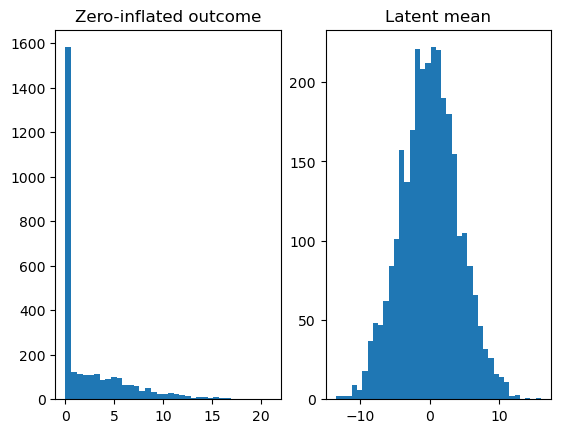

------------------------------------
Feature variance is 17.435436900538836
total variance is34.870873801077664
Fraction of variance explained is 0.5000000000000001
------------------------------------


In [4]:
# Loading the data
data_sim = sim_tobit_data(n = 3000, p =50, p_causal = 20, 
                          rho = 0.1, var = 1, n_matrix = 1, h = 0.5, p_confound = 0)
z, X, Xs, latent_mean, var_feature, var_total, true_beta, y_star = data_sim.gen_data()
show_sim(z, latent_mean, var_total)
z_df = pd.DataFrame(z, columns = ['outcome'])
feature_df = pd.DataFrame(X, columns = ['c'+str(i) for i in range(1,X.shape[1]+1)])
data = pd.concat([z_df, feature_df], axis = 1)

In [5]:
# Adding categorical features that is included in the FVE calculation (null effect)
data['cate_feature_1'] = np.random.choice(range(1,4), data.shape[0], replace = True)
data['cate_feature_1'] = np.where(data['cate_feature_1'] == 1, 'C1', np.where(data['cate_feature_1'] == 2, 'C2', 'C3'))
data['cate_feature_2'] = np.where(np.random.binomial(1, 0.5, size = data.shape[0]), 'T', 'F')
# Add in two true beta for the additional categorical features
true_beta = np.concatenate([np.array([0,0, 0]), true_beta])
# Adding confounding categroical features (null effect)
data['cate_conf_1'] = np.random.choice(range(1,4), data.shape[0], replace = True)
data['cate_conf_1'] = np.where(data['cate_conf_1'] == 1, 'C1', np.where(data['cate_conf_1'] == 2, 'C2', 'C3'))
data['cate_conf_2'] = np.where(np.random.binomial(1, 0.5, size = data.shape[0]), 'T', 'F')

At iteration 0, the loss is 8718.739874598796


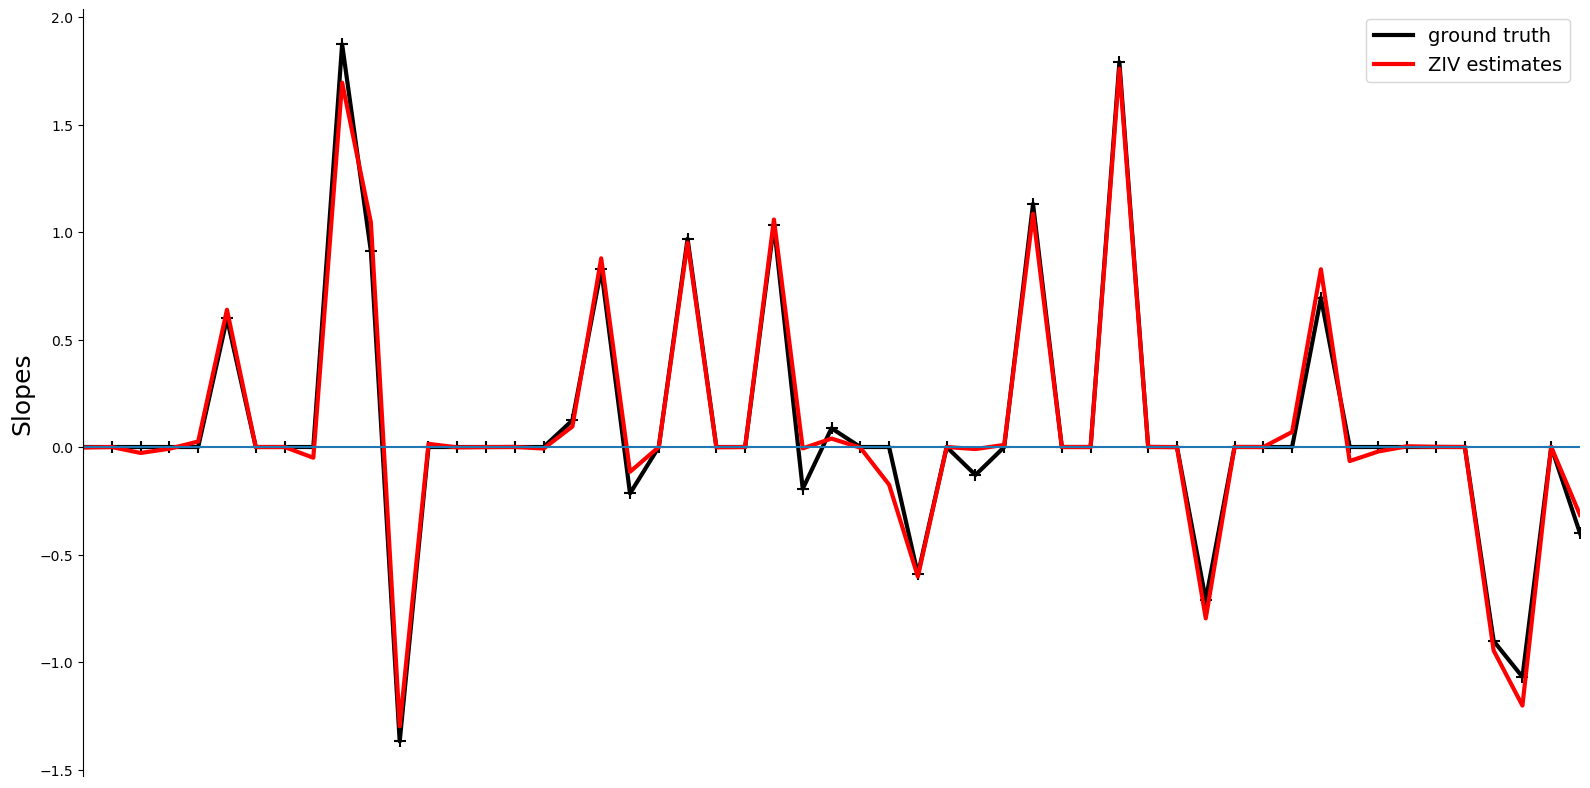

In [6]:
# Initialize and Fit the model
ziv = ZIV(data = data, outcome_name = 'outcome', 
          feature_conti_name = list(data.columns[1:51]), 
          feature_cate_name = ['cate_feature_1', 'cate_feature_2'],
          confounder_conti_name = [], 
          confounder_cate_name = ['cate_conf_1', 'cate_conf_2'],
          batch_size = None, device = 'cpu')
FVE_df, coefficient_df, train_prediction, train_error = ziv.fit(lr = 0.5, 
                                                                min_loss_stop_fraction_diff = 0.5, 
                                                                lr_schedule_step = 1000, lr_sch_gamma = 0.8, 
                                                                verbose = True, true_beta = true_beta)

In [7]:
# Prediction
ziv.predict(data)

array([[ 9.01596948,  0.90847832, -1.45072219, ..., -1.73282878,
        -2.37338617,  2.1163967 ],
       [ 9.05999191,  0.95250075, -1.40669975, ..., -1.68880634,
        -2.32936373,  2.16041913],
       [ 8.82670314,  0.71921198, -1.63998853, ..., -1.92209512,
        -2.56265251,  1.92713036],
       ...,
       [ 9.01596948,  0.90847832, -1.45072219, ..., -1.73282878,
        -2.37338617,  2.1163967 ],
       [ 8.78336022,  0.67586906, -1.68333144, ..., -1.96543803,
        -2.60599542,  1.88378744],
       [ 8.82670314,  0.71921198, -1.63998853, ..., -1.92209512,
        -2.56265251,  1.92713036]])

# Inference results

In [10]:
# Total signal profile
FVE_df

{'FVE': [0.5116332154540278],
 'FVE_upper': [0.5410831408278844],
 'FVE_lower': [0.4798324116779564],
 'global_non_null': [0.36201812471834255],
 'global_non_null_upper': [0.512376612853885],
 'global_non_null_lower': [0.2267012712649945],
 'feature_variance': [17.92630162962612],
 'noise_variance': [17.101670898289857]}

In [11]:
# Local feature profile for each feature
coefficient_df

,feature_names,beta,pi
0,cate_feature_1_C2,-0.114848,0.019588
1,cate_feature_1_C3,-0.022498,0.003756
2,cate_feature_2_T,-0.166261,0.166557
3,c1,-0.090120,0.089212
4,c2,0.151599,0.169465
5,c3,0.638648,0.999827
6,c4,-0.003238,0.005826
7,c5,-0.042751,0.001869
8,c6,-0.190006,0.262447
9,c7,1.694836,0.999967
